# Import Libraries and Data

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import re

import numpy as np
from functools import reduce
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from sklearn import linear_model
import torch
import torch.nn as nn
from tqdm import tqdm

In [40]:
DATA_PATH = '../data'

In [41]:
cons = pd.read_parquet(f'{DATA_PATH}/raw/q2_consDF_final.pqt')
acct = pd.read_parquet(f'{DATA_PATH}/raw/q2_acctDF_final.pqt')
inflows = pd.read_parquet(f'{DATA_PATH}/raw/q2_inflows_final.pqt')
outflows = pd.read_parquet(f'{DATA_PATH}/raw/q2_outflows_final.pqt')

# Create Features

In [42]:
features = []

### Max Balance at time of evaluation

In [43]:
balance_var = acct[['prism_consumer_id','balance','balance_date']].groupby('prism_consumer_id').agg({
    'balance':['min', 'max', 'std'],
    'balance_date':['max']
}).reset_index()
balance_var.fillna(0.0, inplace=True)

balance_var.columns = balance_var.columns.to_flat_index().map(lambda x: x[1] + x[0])
features.append(balance_var)
balance_var.head()

,prism_consumer_id,minbalance,maxbalance,stdbalance,maxbalance_date
0,0,6182.60,9907.23,2633.711130,2023-04-13
1,2,8079.43,17426.83,6609.609926,2022-02-15
2,4,0.00,4871.39,2644.903088,2021-08-13
3,7,517.95,7071.18,3766.231217,2021-08-08
4,9,13348.76,13348.76,0.000000,2023-04-19


### Disposable Income

In [44]:
cons_eval_dates = cons.sort_values('evaluation_date')[['prism_consumer_id','evaluation_date']]
outflow_merged = pd.merge(outflows, cons_eval_dates, on="prism_consumer_id", how="left")
inflow_merged = pd.merge(inflows, cons_eval_dates, on="prism_consumer_id", how="left")
outflow_merged['amount'] = outflow_merged['amount'] * -1
total_balance = pd.concat([inflow_merged, outflow_merged])

total_balance = total_balance[total_balance['posted_date'] <= total_balance['evaluation_date']]

total_balance = total_balance[[
        'prism_consumer_id',
        'amount',
        'posted_date',
]].groupby('prism_consumer_id').agg({'amount':['sum'],'posted_date':['min','max']})

total_balance['date_range'] = pd.to_timedelta(total_balance['posted_date','max'] - total_balance['posted_date','min']).dt.days / 365
total_balance = pd.DataFrame({
    'total_balance': total_balance['amount','sum'] / total_balance['date_range'], 
    'total_balance_date': total_balance['posted_date', 'max']
}).reset_index()

features.append(total_balance)
total_balance.head()

,prism_consumer_id,total_balance,total_balance_date
0,0,15154.285773,2023-04-12
1,2,1546.065942,2022-02-14
2,4,3377.081389,2021-08-12
3,7,7311.445429,2021-08-06
4,9,5873.815289,2023-04-18


### Monthly Features

In [45]:
outflow_valid = outflow_merged[outflow_merged['posted_date'] <= outflow_merged['evaluation_date']]
outflow_counts = outflow_valid.groupby('prism_consumer_id').agg({
    'amount':['count','sum'],
    'posted_date':['min','max'],
}).reset_index()

outflow_counts['date_range'] = pd.to_timedelta(outflow_counts['posted_date','max'] - outflow_counts['posted_date','min']).dt.days / 365 * 12

outflow_counts = pd.DataFrame({
    'prism_consumer_id': outflow_counts['prism_consumer_id'],
    'avg_monthly_spending': -1 * outflow_counts['amount','sum'] / outflow_counts['date_range'],
    'num_monthly_purchase': outflow_counts['amount','count'] / outflow_counts['date_range'],
    # 'monthly_purchase_date': outflow_counts['posted_date','max'],
})

outflow_counts.replace([np.inf, -np.inf], 0.0, inplace=True)
features.append(outflow_counts)
outflow_counts.head()

,prism_consumer_id,avg_monthly_spending,num_monthly_purchase
0,0,7703.614883,80.915055
1,2,9354.337258,98.743961
2,4,30563.426238,33.035880
3,7,23188.278116,138.265235
4,9,11186.144777,79.267677


**Savings Feature - count of how many times someone has pulled from savings account**

In [46]:
transfer_from_savings = inflows[inflows['category_description']=='SELF_TRANSFER']
transfer_from_savings = transfer_from_savings[transfer_from_savings['memo_clean'].str.contains('Savings')]
count_tfs = transfer_from_savings.groupby('prism_consumer_id').count().reset_index()
inflow_ids = pd.merge(inflows[['prism_consumer_id']], count_tfs, on='prism_consumer_id', how='left')
inflow_ids = inflow_ids.fillna(0).drop_duplicates(subset=['prism_consumer_id']).reset_index()[['prism_consumer_id', 'memo_clean']]

features.append(inflow_ids)
inflow_ids

,prism_consumer_id,memo_clean
0,0,0.0
1,2,0.0
2,4,0.0
3,7,0.0
4,9,0.0
...,...,...
2973,3991,63.0
2974,3992,0.0
2975,3993,22.0
2976,3996,241.0


### Merge all features into feature matrix

In [47]:
feature_df = reduce(
    lambda left,right: pd.merge(left,right, on='prism_consumer_id', how='outer'), 
    features
)

feature_dates = re.findall(r"\w+_date", str(list(feature_df.columns)))
feature_df['feature_date'] = feature_df[feature_dates].max(axis=1)
feature_df.drop(feature_dates, axis=1, inplace=True)
feature_df.fillna(0.0, inplace=True)
feature_df

,prism_consumer_id,minbalance,maxbalance,stdbalance,total_balance,avg_monthly_spending,num_monthly_purchase,memo_clean,feature_date
0,0,6182.60,9907.23,2633.711130,15154.285773,7703.614883,80.915055,0.0,2023-04-13
1,2,8079.43,17426.83,6609.609926,1546.065942,9354.337258,98.743961,0.0,2022-02-15
2,4,0.00,4871.39,2644.903088,3377.081389,30563.426238,33.035880,0.0,2021-08-13
3,7,517.95,7071.18,3766.231217,7311.445429,23188.278116,138.265235,0.0,2021-08-08
4,9,13348.76,13348.76,0.000000,5873.815289,11186.144777,79.267677,0.0,2023-04-19
...,...,...,...,...,...,...,...,...,...
2973,5941,2058.81,2058.81,0.000000,-1816.084426,4052.617937,84.468579,0.0,2023-01-06
2974,5943,2431.44,2431.44,0.000000,4121.415493,5769.212382,25.538522,0.0,2023-02-03
2975,5944,45.74,45.74,0.000000,-765.389130,1987.821739,88.605072,0.0,2023-02-01
2976,5945,59.88,59.88,0.000000,-1557.370000,3474.895833,103.541667,0.0,2023-02-02


## Final Feature Matrix

In [48]:
sorted_cons = cons.sort_values('evaluation_date')

dropped_cols = ['prism_consumer_id', 'evaluation_date', 'feature_date', 'APPROVED']
feature_matrix = pd.merge(sorted_cons, feature_df, on='prism_consumer_id', how='left')

# Make sure no invalid training data is pulled
assert np.mean(feature_matrix['evaluation_date'] < feature_matrix['feature_date']) == 0, "Features pulled from dates after evaluation_date"
feature_matrix.drop(dropped_cols, axis=1, inplace=True)

In [49]:
feature_matrix.iloc[:,0].head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: FPF_TARGET, dtype: float64

In [50]:
# Train Test Split
TEST_SIZE = 0.33
X = feature_matrix.iloc[:,1:].to_numpy()
y = feature_matrix.iloc[:,0].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size = TEST_SIZE, 
    random_state=42
)

# Prototype Model to Predict Default Risk

In [51]:
model = linear_model.LogisticRegression()

In [52]:
model.fit(X_train, y_train)

/Users/darrenjiang/opt/anaconda3/envs/dsc180/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [53]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

cm_train = confusion_matrix(y_train, train_pred)
cm_test = confusion_matrix(y_test, test_pred)

tn_train, fp_train, fn_train, tp_train = cm_train.ravel()
tn_test, fp_test, fn_test, tp_test = cm_test.ravel()

In [54]:
print(f"Training Accuracy: {np.mean(model.predict(X_train) == y_train):.4f}")
print(f"Testing Accuracy: {np.mean(model.predict(X_test) == y_test):.4f}")
print("Coefficients: \n", model.coef_, "\n")

print(f"tn_train: {tn_train}, fp_train: {fp_train}, fn_train: {fn_train}, tp_train: {tp_train}")
print(f"tn_test:  {tn_test},  fp_test:  {fp_test},  fn_test:  {fn_test}, tp_test:  {tp_test}")

Training Accuracy: 0.8040
Testing Accuracy: 0.8352
Coefficients: 
 [[-3.91156499e-03  3.20945121e-03 -1.33100166e-02 -1.28421120e-05
  -1.35076585e-04  7.25960832e-04  5.95318527e-03]] 

tn_train: 1566, fp_train: 32, fn_train: 359, tp_train: 38
tn_test:  808,  fp_test:  11,  fn_test:  151, tp_test:  13


# Prototype 2: Basic Sequential NN

In [65]:
# Define the model
model = nn.Sequential(
    nn.Linear(7, 12),
    nn.ReLU(),
    nn.Linear(12, 24),
    nn.ReLU(),
    nn.Linear(24, 24),
    nn.ReLU(),
    nn.Linear(24, 12),
    nn.ReLU(),
    nn.Linear(12, 6),
    nn.ReLU(),
    nn.Linear(6, 1)
)

In [66]:
# loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [67]:
# training parameters
n_epochs = 500   # number of epochs to run
batch_size = 5  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)

In [68]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train * 2 - 1, dtype=torch.float32).reshape(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test * 2 - 1, dtype=torch.float32).reshape(-1, 1)

In [69]:
train_history = []
valid_history = []
 
# training loop
bar = tqdm(range(n_epochs))
for epoch in bar:
    model.train()
    bar.set_description(f"Epoch {epoch+1}")
    for start in batch_start:
        # take a batch
        X_batch = X_train_tensor[start:start+batch_size]
        y_batch = y_train_tensor[start:start+batch_size]
        # forward pass
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        # update weights
        optimizer.step()
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred_train = model(X_train_tensor)
    y_pred_test = model(X_test_tensor)
    train_loss = float(loss_fn(y_pred_train, y_train_tensor))
    test_loss = float(loss_fn(y_pred_test, y_test_tensor))
    
    bar.set_postfix(Train_MSE = float(train_loss), Valid_MSE = float(test_loss))
    train_history.append(train_loss)
    valid_history.append(test_loss)

Epoch 500: 100%|██████████| 500/500 [05:00<00:00,  1.66it/s, Train_MSE=0.495, Valid_MSE=0.489]


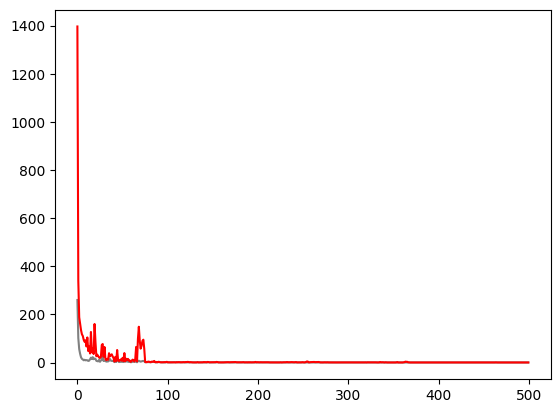

In [73]:
plt.plot(train_history, 'gray')
plt.plot(valid_history, 'r')

In [93]:
# train_pred = model.predict(X_train)
def standardize_output(arr):
    return ((arr - min(arr)) / (max(arr) - min(arr)))

train_pred_raw = model(X_train_tensor).detach().numpy()[:,0]
train_pred_prob = standardize_output(train_pred_raw)
train_pred = train_pred_prob > 0.6

test_pred_raw = model(X_test_tensor).detach().numpy()[:,0]
test_pred_prob = standardize_output(test_pred_raw)
test_pred = test_pred_prob > 0.6

cm_train = confusion_matrix(y_train, train_pred)
cm_test = confusion_matrix(y_test, test_pred)

tn_train, fp_train, fn_train, tp_train = cm_train.ravel()
tn_test, fp_test, fn_test, tp_test = cm_test.ravel()

In [95]:
tn_train, fp_train, fn_train, tp_train = cm_train.ravel()
tn_test, fp_test, fn_test, tp_test = cm_test.ravel()
print(f"Training Accuracy: {np.mean(train_pred == y_train):.4f}")
print(f"Testing Accuracy: {np.mean(test_pred == y_test):.4f}")

print(f"tn_train: {tn_train}, fp_train: {fp_train}, fn_train: {fn_train}, tp_train: {tp_train}")
print(f"tn_test:  {tn_test},  fp_test:  {fp_test},  fn_test:  {fn_test}, tp_test:  {tp_test}")

Training Accuracy: 0.8090
Testing Accuracy: 0.7640
tn_train: 1597, fp_train: 1, fn_train: 380, tp_train: 17
tn_test:  651,  fp_test:  168,  fn_test:  64, tp_test:  100
